# Demo Training & Testing of Word-Level Lip reading Model

### 0. Getting All necessary Dependencies

In [1]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [8]:
# Making sure TF uses GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. Visualizing Dataset

In [1]:
from videos import *

In [2]:
# loading video dsa gfg intro video
clip = VideoFileClip("..\\Dataset\\Urdu\\2\\aap_kese_hai_jee_kyun_do\\_video.avi")

frames = clip_to_list(clip)


In [3]:
len(frames)

90

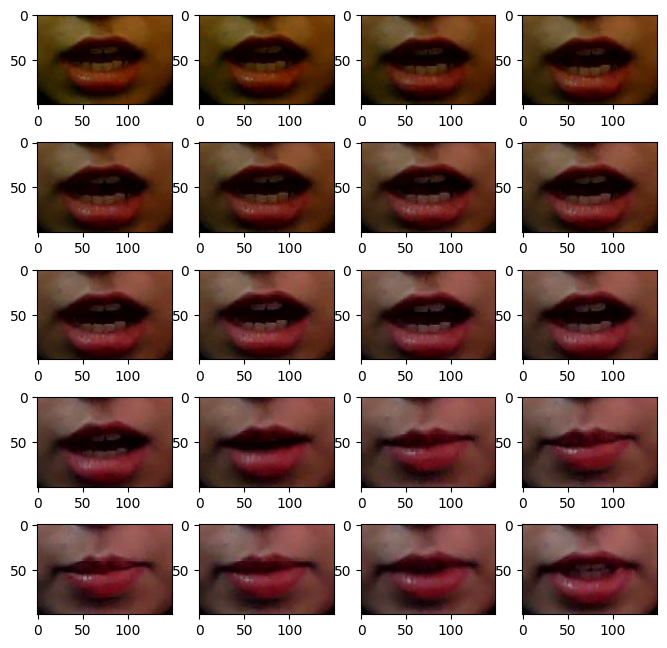

In [4]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
ind = 0
for i in range(1, columns*rows +1):
    img = frames[ind]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    ind+=1
plt.show()

In [5]:
s = np.array(frames)

In [6]:
s.shape

(90, 100, 150, 3)

In [7]:
l =     read_and_segment_video("..\\Dataset\\Urdu\\2\\aap_kese_hoon_jee_kon_aath")

15
11
14
9
9
11
12
11


### 2. Getting Dataset

In [3]:
# Getting dataset generation function
from Dataset import create_word_level_dataset

In [4]:
# Currently processing only two videos(two sentences)
# CLASSES LIST HAS BEEN CHANGED INSIDE THE FUNCTION, CHANGE IT TO ORIGINAL WHEN TRAINING ON WHOLE DATASET
features, labels = create_word_level_dataset()

mein_kese_thay_jee_kyun_chaar
aap_kese_tha_jee_kyun_paanch
list index out of range


In [5]:
print(len(features))
print(len(labels))

15
15


In [6]:
# TEMP: change back to original !!!!
CLASSES_LIST = ['<sil>', 'ek', 'paanch', 'hum', 'han', 'chaar', 'kyun', 'wo', 'theen', 'kab', 'nai', 'tha', 'aap', 'nau', 'thay', 'kitne', 'hoon', 'do', 'jee', 'hai', 'kidhar', 'kon', 'konsa', 'mein', 'aath', 'kese', 'chhae', 'saath']
CLASSES_LIST = ['<sil>','aap','chaar','jee','kese','kyun','mein','paanch','tha','thay']
tmp_list = []

for i in range(len(labels)):
    print(labels[i], " : ", CLASSES_LIST[labels[i]])
    tmp_list.append(CLASSES_LIST[labels[i]])

0  :  <sil>
6  :  mein
4  :  kese
9  :  thay
3  :  jee
5  :  kyun
2  :  chaar
0  :  <sil>
0  :  <sil>
1  :  aap
4  :  kese
8  :  tha
3  :  jee
5  :  kyun
7  :  paanch


In [23]:
set(tmp_list)

{'<sil>',
 'aap',
 'chaar',
 'jee',
 'kese',
 'kyun',
 'mein',
 'paanch',
 'tha',
 'thay'}

In [7]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [8]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [9]:
features.shape

(15, 7, 100, 150, 3)

In [10]:
labels_train.shape

(11, 10)

### 3. Training Model

In [11]:
# Important variables DEFINED IN PREPROCESSOR FILES
SEQUENCE_LENGTH = 7 
IMAGE_HEIGHT = 100 
IMAGE_WIDTH = 150

In [12]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [13]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 7, 100, 150, 16)  448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 25, 37, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 7, 25, 37, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 7, 25, 37, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 7, 6, 9, 32)      0

In [14]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
2/2 [==============================] - 35s 644ms/step - loss: 2.4076 - accuracy: 0.0000e+00 - val_loss: 2.2182 - val_accuracy: 0.3333
Epoch 2/70
2/2 [==============================] - 0s 38ms/step - loss: 2.2090 - accuracy: 0.1250 - val_loss: 2.2237 - val_accuracy: 0.3333
Epoch 3/70
2/2 [==============================] - 0s 38ms/step - loss: 2.1151 - accuracy: 0.1250 - val_loss: 2.2236 - val_accuracy: 0.3333
Epoch 4/70
2/2 [==============================] - 0s 37ms/step - loss: 2.0905 - accuracy: 0.1250 - val_loss: 2.2319 - val_accuracy: 0.3333
Epoch 5/70
2/2 [==============================] - 0s 41ms/step - loss: 2.0745 - accuracy: 0.0000e+00 - val_loss: 2.2302 - val_accuracy: 0.3333
Epoch 6/70
2/2 [==============================] - 0s 35ms/step - loss: 2.0543 - accuracy: 0.0000e+00 - val_loss: 2.2358 - val_accuracy: 0.3333
Epoch 7/70
2/2 [==============================] - 0s 37ms/step - loss: 2.0526 - accuracy: 0.1250 - val_loss: 2.2335 - val_accuracy: 0.3333
Epoch 8/70
2/

In [15]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 49ms/step - loss: 2.4117 - accuracy: 0.0000e+00


In [16]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

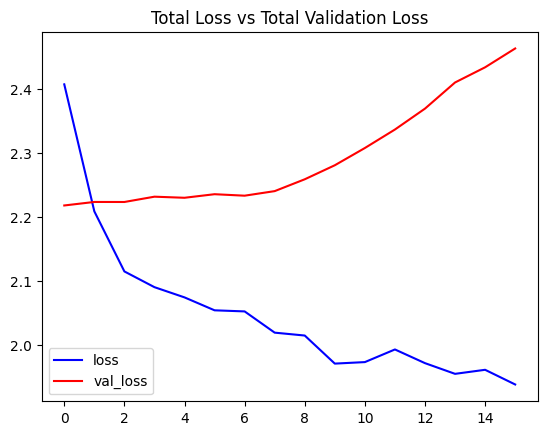

In [19]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

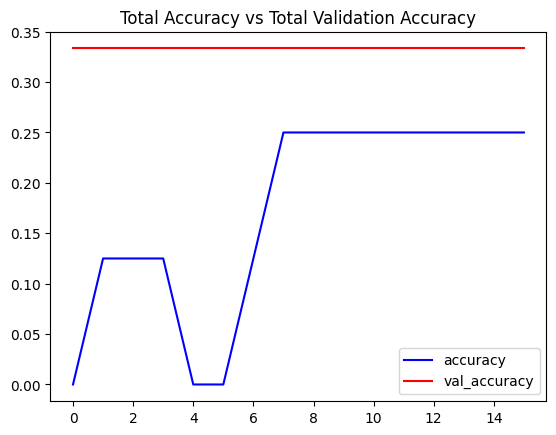

In [20]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')